# 第一次作业

在2.1和2.2小节的基础上，探究网络层数、隐藏层神经元个数和激活函数对网络在MNIST数据集上的性能的影响。

1. 将网络层数调整为{1,2,3,4,5}，观察模型在训练集和测试集上的损失函数/准确率的变化。
1. 固定网络层数为2，将隐藏层神经元个数调整为{1,4,16,64}，观察模型在训练集和测试集上的损失函数/准确率的变化。
1. 固定网络层数为2，去掉网络中的激活函数，观察模型在训练集和测试集上的损失函数/准确率。
1. 对于上述的现象，我们能解释其发生的原因吗？

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"using device: {device}")

using device: cuda


In [2]:
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

# 下载MNIST数据集中的训练集，并保存到data文件夹
data_train = datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor())
# 加载MNIST数据集中的测试集
data_test = datasets.MNIST('data', train=False, download=True, transform=transforms.ToTensor())

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
def create_model(n_layers, in_features, out_features, n_hidden, activation=nn.ReLU()):
    model = []

    assert n_layers > 0, "num of layers should be larger than 0"

    if n_layers == 1:
        model.append(nn.Linear(in_features, out_features))
    else:
        model.append(nn.Linear(in_features, n_hidden))
        if activation is not None:
            model.append(activation)
        
        for i in range(n_layers-2):
            model.append(nn.Linear(n_hidden, n_hidden))

            if activation is not None:
                model.append(activation)
        
        model.append(nn.Linear(n_hidden, out_features))

    model = nn.Sequential(*model)

    return model

In [4]:
@torch.no_grad() # 由于测试的时候不需要求导，可以暂时关闭autograd，提高速度，节约内存
def test(model, data, batch_size=128):
    num_correct = 0 # 预测正确的图片数
    num_total = 0 # 总共的图片数
    
    test_loader = torch.utils.data.DataLoader(data, 
                                              batch_size=batch_size, 
                                              shuffle=False)
    for data in test_loader: # 按batch取出测试集中的数据
        img, label = data
        img = img.view((img.shape[0], -1))
        img = img.to(device)
        label = label.to(device)
        output = model(img)
        predicted = output.argmax(1)
        num_total += len(label)
        num_correct += (predicted == label).sum()

    # print('共有{}张图片，准确率为: {:.2f}%'.format(num_correct, 100 * num_correct / num_total))
    return (num_correct / num_total).item()

In [5]:
# 我们定义一个train函数来封装我们的训练过程
def train(model, data, data_test, num_epochs=5, learning_rate=1e-3, batch_size=32):
    # 定义一个优化器，Adam优化器是梯度下降法的一个变种
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate, 
                                 weight_decay=1e-5) # weight_decay表示L2正则项
    
    # 把训练数据封装到DataLoader，这样便于我们以及选取batch以及打乱数据顺序
    train_loader = torch.utils.data.DataLoader(data, 
                                               batch_size=batch_size, 
                                               shuffle=True)
    # 定义损失函数
    criterion = nn.CrossEntropyLoss()

    hist = {"loss": [], "acc_train": [], "acc_test": []}
    
    for epoch in range(num_epochs):
        loss_total = 0 # 定义一个loss_total变量来记录我们的loss变化
        for data in train_loader:
            # 梯度清零
            optimizer.zero_grad()
            
            img, label = data
            img = img.view((img.shape[0], -1))
            img = img.to(device)
            label = label.to(device)
            
            # 前向传播和反向传播
            output = model(img)
            loss = criterion(output, label)
            loss.backward()
            
            # 优化参数
            optimizer.step()
        
        # training history
        loss_total += loss.item()
        acc_train= test(model, data_train, batch_size)
        acc_test = test(model, data_test, batch_size)

        hist["loss"].append(loss_total)
        hist["acc_train"].append(acc_train)
        hist["acc_test"].append(acc_test)
        
        print('Epoch: {}, Training Loss: {:.4f}, Training Accuracy: {:.4f}, Test Accuracy: {:.4f}'.format(epoch+1, loss_total, acc_train, acc_test))
    
    return hist

# Q1

In [6]:
n_layers = [1, 2, 3, 4, 5]
hists = []

for n_layer in n_layers:
    model = create_model(n_layer, 784, 10, 256)
    model = model.to(device) 

    print(f"n_layer: {n_layer}")
    hist = train(model, data_train, data_test, num_epochs=10)
    hists.append(hist)
    
    print()

n_layer: 1
Epoch: 1, Training Loss: 0.1924, Training Accuracy: 0.9133, Test Accuracy: 0.9160
Epoch: 2, Training Loss: 0.1105, Training Accuracy: 0.9223, Test Accuracy: 0.9209
Epoch: 3, Training Loss: 0.1778, Training Accuracy: 0.9249, Test Accuracy: 0.9238
Epoch: 4, Training Loss: 0.1362, Training Accuracy: 0.9252, Test Accuracy: 0.9235
Epoch: 5, Training Loss: 0.2999, Training Accuracy: 0.9265, Test Accuracy: 0.9252
Epoch: 6, Training Loss: 0.4047, Training Accuracy: 0.9294, Test Accuracy: 0.9269
Epoch: 7, Training Loss: 0.3022, Training Accuracy: 0.9309, Test Accuracy: 0.9288
Epoch: 8, Training Loss: 0.2634, Training Accuracy: 0.9323, Test Accuracy: 0.9261
Epoch: 9, Training Loss: 0.4156, Training Accuracy: 0.9310, Test Accuracy: 0.9244
Epoch: 10, Training Loss: 0.1146, Training Accuracy: 0.9328, Test Accuracy: 0.9270

n_layer: 2
Epoch: 1, Training Loss: 0.0651, Training Accuracy: 0.9662, Test Accuracy: 0.9641
Epoch: 2, Training Loss: 0.0171, Training Accuracy: 0.9771, Test Accuracy:

Text(0.5, 1.0, 'Accuracy Curve')

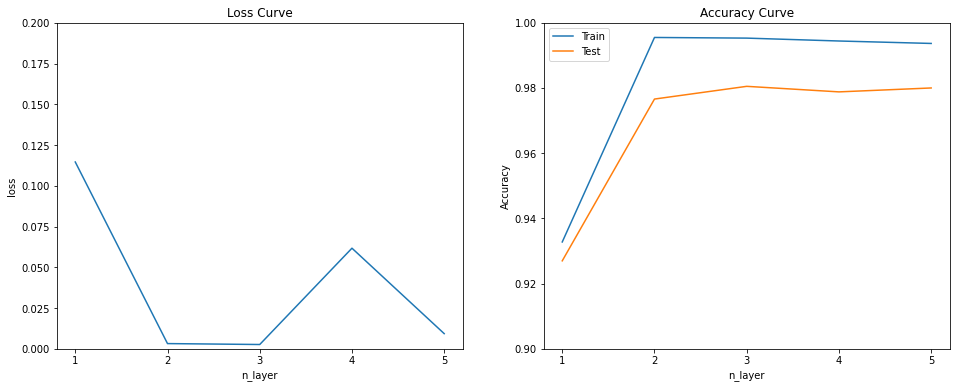

In [7]:
train_loss = []
train_acc  = []
test_acc   = []

for n_layer, hist in zip(n_layers, hists):
    train_loss.append(hist['loss'][-1])
    train_acc.append(hist['acc_train'][-1])
    test_acc.append(hist['acc_test'][-1])

plt.subplots(ncols=2, figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(n_layers, train_loss)
plt.ylim(0.0, 0.2)
_ = plt.xticks(n_layers, n_layers)
plt.xlabel("n_layer")
plt.ylabel("loss")
plt.title("Loss Curve")

plt.subplot(1, 2, 2)
plt.plot(n_layers, train_acc, label="Train")
plt.plot(n_layers, test_acc, label="Test")
plt.ylim(0.9, 1.0)
_ = plt.xticks(n_layers, n_layers)
plt.xlabel("n_layer")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Curve")

# Q2

In [8]:
n_hiddens = [1, 4, 16, 64]
hists = []

for n_hidden in n_hiddens:
    model = create_model(2, 784, 10, n_hidden)
    model = model.to(device) 

    print(f"n_hidden: {n_hidden}")
    hist = train(model, data_train, data_test, num_epochs=10)
    hists.append(hist)
    
    print()

n_hidden: 1
Epoch: 1, Training Loss: 2.0368, Training Accuracy: 0.2741, Test Accuracy: 0.2823
Epoch: 2, Training Loss: 1.7225, Training Accuracy: 0.3022, Test Accuracy: 0.3087
Epoch: 3, Training Loss: 1.6687, Training Accuracy: 0.3239, Test Accuracy: 0.3281
Epoch: 4, Training Loss: 1.6298, Training Accuracy: 0.3218, Test Accuracy: 0.3292
Epoch: 5, Training Loss: 1.7072, Training Accuracy: 0.3441, Test Accuracy: 0.3478
Epoch: 6, Training Loss: 1.7552, Training Accuracy: 0.3412, Test Accuracy: 0.3437
Epoch: 7, Training Loss: 1.5065, Training Accuracy: 0.3499, Test Accuracy: 0.3494
Epoch: 8, Training Loss: 1.4938, Training Accuracy: 0.3453, Test Accuracy: 0.3456
Epoch: 9, Training Loss: 1.6820, Training Accuracy: 0.3449, Test Accuracy: 0.3417
Epoch: 10, Training Loss: 1.6972, Training Accuracy: 0.3572, Test Accuracy: 0.3581

n_hidden: 4
Epoch: 1, Training Loss: 0.6024, Training Accuracy: 0.8205, Test Accuracy: 0.8253
Epoch: 2, Training Loss: 0.4628, Training Accuracy: 0.8418, Test Accurac

Text(0.5, 1.0, 'Accuracy Curve')

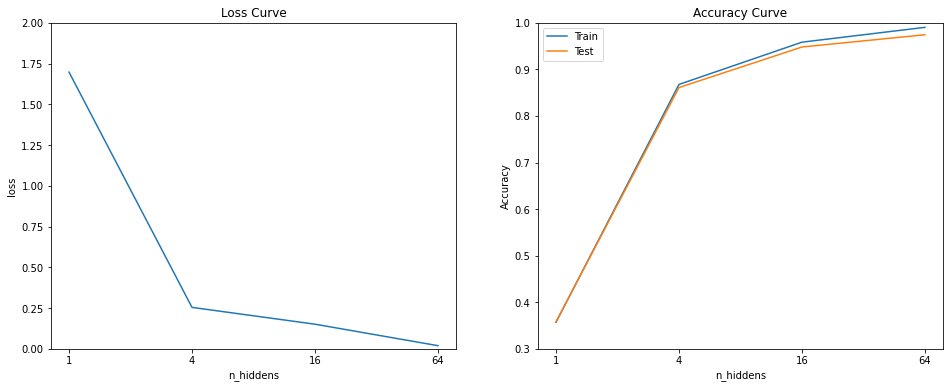

In [9]:
train_loss = []
train_acc  = []
test_acc   = []

for n_hidden, hist in zip(n_hiddens, hists):
    train_loss.append(hist['loss'][-1])
    train_acc.append(hist['acc_train'][-1])
    test_acc.append(hist['acc_test'][-1])

plt.subplots(ncols=2, figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss)
plt.ylim(0.0, 2.0)
_ = plt.xticks(np.arange(len(n_hiddens)), n_hiddens)
plt.xlabel("n_hiddens")
plt.ylabel("loss")
plt.title("Loss Curve")

plt.subplot(1, 2, 2)
plt.plot(train_acc, label="Train")
plt.plot(test_acc, label="Test")
plt.ylim(0.3, 1.0)
_ = plt.xticks(np.arange(len(n_hiddens)), n_hiddens)
plt.xlabel("n_hiddens")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Curve")

# Q3

In [10]:
model = create_model(2, 784, 10, 64, activation=None)
model = model.to(device)
hist = train(model, data_train, data_test, num_epochs=10)

Epoch: 1, Training Loss: 0.0398, Training Accuracy: 0.9208, Test Accuracy: 0.9207
Epoch: 2, Training Loss: 0.1933, Training Accuracy: 0.9227, Test Accuracy: 0.9229
Epoch: 3, Training Loss: 0.5577, Training Accuracy: 0.9259, Test Accuracy: 0.9214
Epoch: 4, Training Loss: 0.2873, Training Accuracy: 0.9283, Test Accuracy: 0.9239
Epoch: 5, Training Loss: 0.2305, Training Accuracy: 0.9228, Test Accuracy: 0.9181
Epoch: 6, Training Loss: 0.0786, Training Accuracy: 0.9272, Test Accuracy: 0.9206
Epoch: 7, Training Loss: 0.1206, Training Accuracy: 0.9259, Test Accuracy: 0.9210
Epoch: 8, Training Loss: 0.4254, Training Accuracy: 0.9299, Test Accuracy: 0.9222
Epoch: 9, Training Loss: 0.4615, Training Accuracy: 0.9267, Test Accuracy: 0.9204
Epoch: 10, Training Loss: 0.4428, Training Accuracy: 0.9297, Test Accuracy: 0.9213
